In [8]:
# Importo las bibliotecas de OpenCV, Numpy y Matplotlib
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Parte 1

## Funciones

In [9]:
# Funcion para crear un filtro gaussiano
def create_gauss_filter(h, w, k_size, sigma):
    # Creo un filtro vacio
    filter = np.zeros((h, w), np.float32)
    # Calculo el centro del filtro
    center = (k_size - 1) // 2
    centerH = h // 2
    centerW = w // 2
    
    # Recorro el filtro
    for i in range(k_size):
        for j in range(k_size):
            # Calculo la distancia al centro
            x = i - center
            y = j - center
            posFilter = centerH - center + i, centerW - center + j
            # Calculo el valor del filtro en la posicion
            filter[posFilter] = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    # Normalizo el filtro
    filter /= np.sum(filter)

    # Creo la transformada de Fourier del filtro
    filterFFT = np.fft.fft2(filter)
    # Retorno el filtro y su transformada de Fourier
    return filter, filterFFT
    


## Utilizacion del filtro

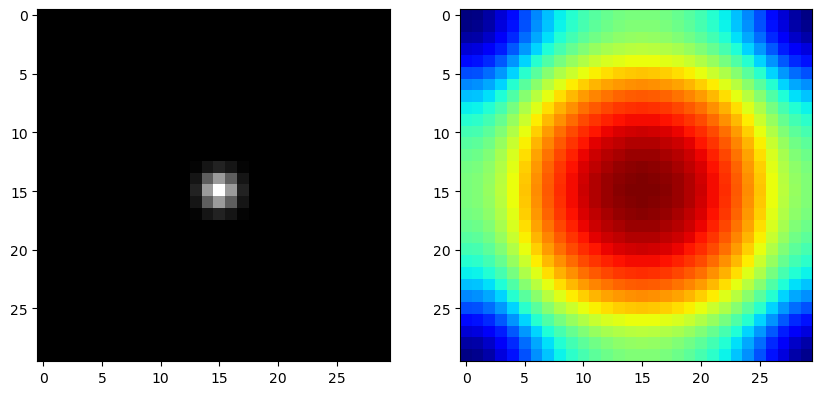

In [43]:
# creo un filtro gaussiano de 5x5 con sigma = 1
filter, filterFFT = create_gauss_filter(30, 30, 5, 1)
# Muestro el filtro como una imagen y su transformada de Fourier
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(filter, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(20*np.log10(np.abs( np.fft.fftshift(filterFFT))), cmap='jet')


En la imagen superior se puede observar el filtro gaussiano con un kernel de 5x5 y sigma de 1 y su transformada de fourier centrada.

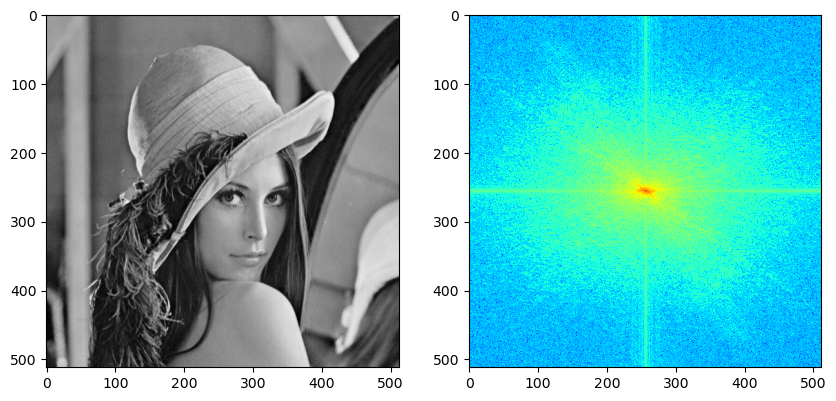

In [11]:
# cargo la imagen
img = cv2.imread('lena.png', cv2.IMREAD_GRAYSCALE)
# Creo la transformada de Fourier de la imagen
imgFFT = np.fft.fft2(img)
# muestro la imagen y su transformada de Fourier una al lado de la otra
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(20*np.log10(np.abs( np.fft.fftshift(imgFFT))), cmap='jet')

En la imagen superior se puede observar la imagen de lena y su transformada de fourier centrada.

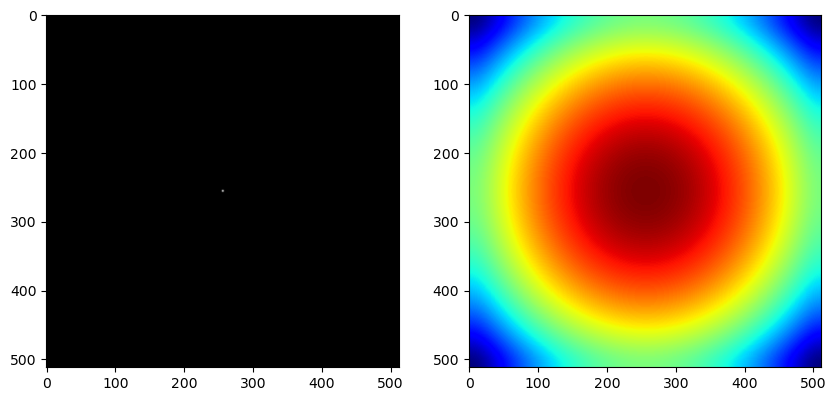

In [34]:
# genero el filtro para la imagen
filter, filterFFT = create_gauss_filter(img.shape[0], img.shape[1], 15, 1)

# Muestro el filtro como una imagen y su transformada de Fourier
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(filter, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(20*np.log10(np.abs( np.fft.fftshift(filterFFT))), cmap='jet')

En la imagen superior se puede observar el filtro gaussiano con un kernel de 15x15 y sigma de 1 y su transformada de fourier centrada.

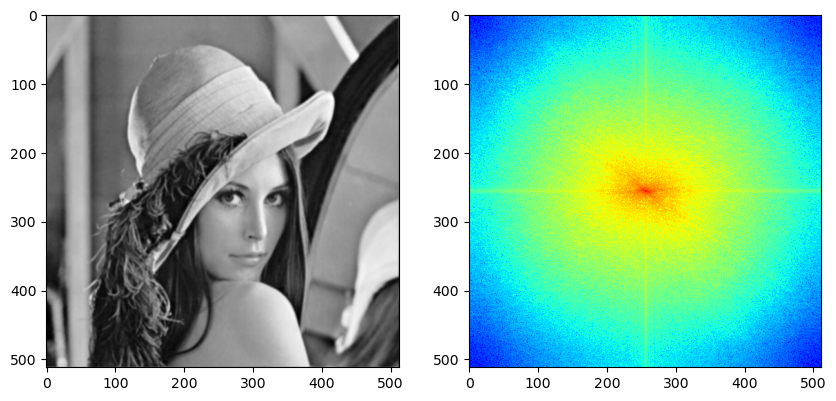

In [35]:
# aplico el filtro a la imagen
imgFilteredFFT = imgFFT * filterFFT
imgFiltered = np.fft.ifftshift(np.fft.ifft2(imgFilteredFFT))
# muestro la imagen filtrada y su transformada de Fourier
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(np.abs(imgFiltered), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(20*np.log10(np.abs( np.fft.fftshift(imgFilteredFFT))), cmap='jet')

En la imagen superior se puede observar la imagen de Lena con un filtro gaussiano aplicado y su transformada de fourier centrada.


Se puede observar como se blurea la imagen al aumentar el sigma del filtro gaussiano.

# Parte 2

## Funciones
Se crea una función para aplicar el método del paper “Image Sharpness Measure for Blurred Images in Frequency Domain” a una imagen, y así tener una métrica para comparar las imágenes originales y las filtradas.

In [14]:
def frequencyDomainImageBlurMeasure(img):
    # 1) computo F la transformada de Fourier de la imagen
    f = np.fft.fft2(img)
    # 2) busco Fc, que se obtiene llevando la transformada de Fourier al centro
    fc = np.fft.fftshift(f)
    # 3) Calculo AF = abs(Fc)
    af = np.abs(fc)
    # 4) Calculo M = max(AF)
    m = np.max(af)
    # 5) Calculo Th que es el numero total de pixeles en F que son mayores a M/1000
    th = np.sum(af > m/1000)
    # 6) Calculo la medida de calidad de la imagen FM = Th / (alto * ancho)
    fm = th / (img.shape[0] * img.shape[1])
    # 7) Retorno FM
    return fm

Se comparan los resultados de la métrica creada entre la imagen original, la imagen con filtro por filtrado espectral, la imagen con el mismo filtro pero por convolución y la imagen con un filtro con mayor sigma para degradarla.


Para el filtrado por convolución se utiliza la función Gaussian Blur de CV2.

In [44]:
# Se realiza el filtrado de la imagen con el metodo de OpenCV utilizando los mismos parametros para el kernel y sigma
imgFilteredCV2 = cv2.GaussianBlur(img, (15,15), 1)
imgFilteredCV2MayorFiltro = cv2.GaussianBlur(img, (15,15), 5)

masureOrigin = frequencyDomainImageBlurMeasure(img)
masureFiltradaMetodoEspectral = frequencyDomainImageBlurMeasure(np.abs(imgFiltered))
measureFiltradaCV2 = frequencyDomainImageBlurMeasure(np.abs(imgFilteredCV2))
measureFiltradaCV2MayorFiltro = frequencyDomainImageBlurMeasure(np.abs(imgFilteredCV2MayorFiltro))

print('Medida de calidad de la imagen original: ', masureOrigin)
print('Medida de calidad de la imagen filtrada (metodo espectral): ', masureFiltradaMetodoEspectral)
print('Medida de calidad de la imagen filtrada (cv2): ', measureFiltradaCV2)
print('Medida de calidad de la imagen filtrada (cv2 sigma 5): ', measureFiltradaCV2MayorFiltro)


Medida de calidad de la imagen original:  0.014591217041015625
Medida de calidad de la imagen filtrada (metodo espectral):  0.012363433837890625
Medida de calidad de la imagen filtrada (cv2):  0.012462615966796875
Medida de calidad de la imagen filtrada (cv2 sigma 5):  0.006084442138671875


Se puede observar que prácticamente no hay diferencia entre aplicar un filtro por convolución o por filtrado espectral.

Al aplicarle un filtro a la imagen la medida devuelta por el método implementado va cayendo, indicando que la calidad de esta empeora.

También se aprecia que al aumentar el sigma del filtro la imagen pierde calidad.

# Parte 3

Se implementa la métrica Absolute central moment (MIS1) del paper “Analysis of focus measure operators in shape-from-focus”

In [41]:
# Implemento metrica de Absolute central moment (MIS1)
def absoluteCentralMoment(img):
    # 1) calculo histograma de la imagen, H
    H = np.histogram(img, bins=256, range=(0, 256), density=True)
    # 2) calculo la media del histograma, u
    u = np.sum(H[0] * np.arange(0, 256))
    # 3) busco los niveles de gris en la imagen y sus frecuencias
    niveles, frecuencia = np.unique(img, return_counts=True)
    # 4) guardo la cantidad de niveles de gris, L
    L = len(niveles)
    # 6) calculo la frecuencia de cada nivel de gris, Pk
    Pk = frecuencia / np.sum(frecuencia)
    # 5) recorro los niveles de gris，calculando el ACMo
    ACMo = 0
    for k in range(L):
        ACMo += np.abs(niveles[k] - u) * Pk[k]
    # 7) retorno el ACMo
    return ACMo

Se realiza la misma comparación que en el punto anterior utilizando la nueva métrica.

In [42]:
# Se realiza el filtrado de la imagen con el metodo de OpenCV utilizando los mismos parametros para el kernel y sigma
imgFilteredCV2 = cv2.GaussianBlur(img, (15,15), 1)
imgFilteredCV2MayorFiltro = cv2.GaussianBlur(img, (15,15), 5)

masureOrigin = absoluteCentralMoment(img)
masureFiltradaMetodoEspectral = absoluteCentralMoment(np.abs(imgFiltered))
measureFiltradaCV2 = absoluteCentralMoment(np.abs(imgFilteredCV2))
measureFiltradaCV2MayorFiltro = absoluteCentralMoment(np.abs(imgFilteredCV2MayorFiltro))

print('Medida de calidad de la imagen original: ', masureOrigin)
print('Medida de calidad de la imagen filtrada (metodo espectral): ', masureFiltradaMetodoEspectral)
print('Medida de calidad de la imagen filtrada (cv2): ', measureFiltradaCV2)
print('Medida de calidad de la imagen filtrada (cv2 sigma 5): ', measureFiltradaCV2MayorFiltro)

Medida de calidad de la imagen original:  37.29029537294991
Medida de calidad de la imagen filtrada (metodo propio):  36.43949419716236
Medida de calidad de la imagen filtrada (cv2):  36.48671326498152
Medida de calidad de la imagen filtrada (cv2 sigma 5):  33.79185476806015


Se puede apreciar como esta métrica puede indicar la misma degradación de imagen que la anterior pero en una escala diferente.

Por ejemplo, la caída porcentual entre la metrica "frequencyDomainImageBlurMeasure" de imagen original y la filtrada con sigma 1 es del 15.26%, y con la métrica "absoluteCentralMoment" es de 2.28%.
Si esta comparación se hace con el filtro con sigma 5, las diferencias entre el valor de métrica de la imagen original y la filtrada son de 58.3% para el primer método y 9.38% para el segundo.


Con estos datos se puede concluir que el método "frequencyDomainImageBlurMeasure" es más sensible y detecta mejor cuando una imagen fue manipulada.